<a href="https://colab.research.google.com/github/Thanisthani/Region_detection_unmask_resnet18/blob/main/Region_detection_keras_resnet_18_unmask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import lib

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Mount g drive

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Add dataset path

In [ ]:
import pathlib
data_dir='/content/gdrive/MyDrive/Region_detection/data/images'
data_dir = pathlib.Path(data_dir).with_suffix('')
test_dir = '/content/gdrive/MyDrive/Region_detection/data/sample_images/test'
test_dir = pathlib.Path(test_dir).with_suffix('')

Pre process the data

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.2,
        horizontal_flip=True)

#For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale=1./255)



Spilit dataset

In [ ]:
train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        class_mode='categorical',
        subset ='training')

validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        class_mode='categorical',
        subset ='validation')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')


Found 1920 images belonging to 2 classes.
Found 480 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


Build model

In [ ]:
def res_block(X, filter, stage):
  #Convolutional_block

  X_copy = X

  f1 , f2, f3 = filter
  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  #Short path

  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  #Identity Block 1

  X_copy = X


  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  #Identity Block 2

  X_copy = X


  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model

input_shape = (224,224,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# 5- stage

X = res_block(X, filter= [512,512,2048], stage= 5)

#Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

#Final layer

X = Flatten()(X)
X = Dense(2, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1[0][0]']        

Compile model

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

Add check point

In [ ]:
#save the best model with lower validation loss
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
checkpointer = ModelCheckpoint(filepath="/content/gdrive/MyDrive/Region_detection/data/ResNet/weights.hdf5", verbose=1, save_best_only=True)

Train model

In [ ]:
history = model.fit(train_generator, epochs = 20, validation_data= validation_generator, callbacks=[checkpointer])#, earlystopping])

Epoch 1/20
60/60 [==============================] - ETA: 0s - loss: 1.0294 - accuracy: 0.8177
Epoch 1: val_loss improved from inf to 1.54711, saving model to /content/gdrive/MyDrive/Region_detection/data/ResNet/weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 489s 7s/step - loss: 1.0294 - accuracy: 0.8177 - val_loss: 1.5471 - val_accuracy: 0.5000
Epoch 2/20
60/60 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8865
Epoch 2: val_loss improved from 1.54711 to 0.82476, saving model to /content/gdrive/MyDrive/Region_detection/data/ResNet/weights.hdf5
60/60 [==============================] - 49s 823ms/step - loss: 0.4082 - accuracy: 0.8865 - val_loss: 0.8248 - val_accuracy: 0.5000
Epoch 3/20
60/60 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.9068
Epoch 3: val_loss improved from 0.82476 to 0.78196, saving model to /content/gdrive/MyDrive/Region_detection/data/ResNet/weights.hdf5
60/60 [==============================] - 45s 760ms/step - loss: 0.3427 - accuracy: 0.9068 - val_loss: 0.7820 - val_accuracy: 0.5542
Epoch 4/20
60/60 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.9333
Epoch 4: val_loss did not improve from 0.78196
60/60 [==

In [ ]:
model.load_weights("/content/gdrive/MyDrive/Region_detection/data/ResNet/weights.hdf5")

Evaluation

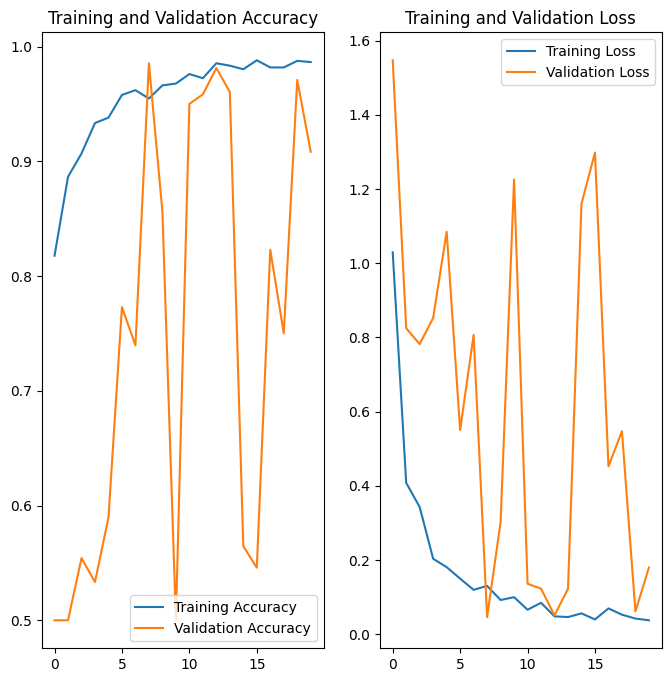

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Find accuracy

In [ ]:
# Evaluate on the validation set
evaluation = model.evaluate(test_generator)

# Print the evaluation results
print(f"Evaluation Results: {evaluation}")
print(f"Accuracy: {evaluation[1]*100:.2f}%")
# print(f"Precision: {evaluation[2]*100:.2f}%")
# print(f"Recall: {evaluation[3]*100:.2f}%")

1/1 [==============================] - 1s 1s/step - loss: 0.6464 - accuracy: 0.7333
Evaluation Results: [0.6463803052902222, 0.7333333492279053]
Accuracy: 73.33%


In [ ]:
test_generator.class_indices

{'EastAsian': 0, 'SouthAsian': 1}

In [ ]:
#assigning label names to the corresponding indexes
labels = {0: 'EastAsian', 1: 'SouthAsian'}

In [ ]:
#loading images and their predictions
import os
import PIL
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

prediction = []
original = []
image = []
count = 0
for i in os.listdir(test_dir):
  for item in os.listdir(os.path.join(test_dir,i)):
    #code to open the image
    img= PIL.Image.open(os.path.join(test_dir,i,item))
    #resizing the image to (224,224)
    img = img.resize((224,224))
    #appending image to the image list
    image.append(img)
    #converting image to array
    img = np.asarray(img, dtype= np.float32)
    #normalizing the image
    img = img / 255
    #reshaping the image in to a 4D array
    img = img.reshape(-1,224,224,3)
    #making prediction of the model
    predict = model.predict(img)
    #getting the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    #appending the predicted class to the list
    prediction.append(labels[predict])
    #appending original class to the list
    original.append(i)


1/1 [==============================] - 0s 23ms/step


In [ ]:
#Getting the test accuracy
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.7


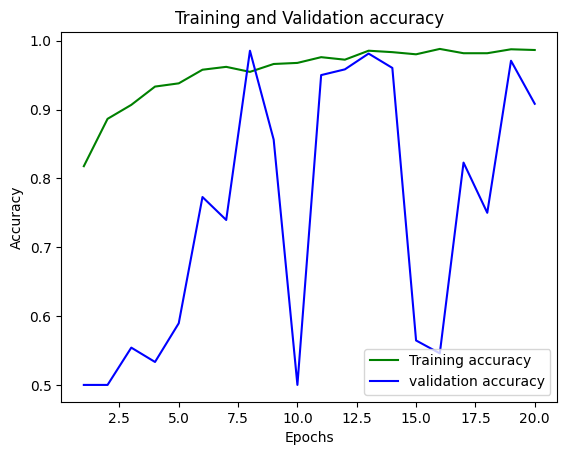

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Visualize the results

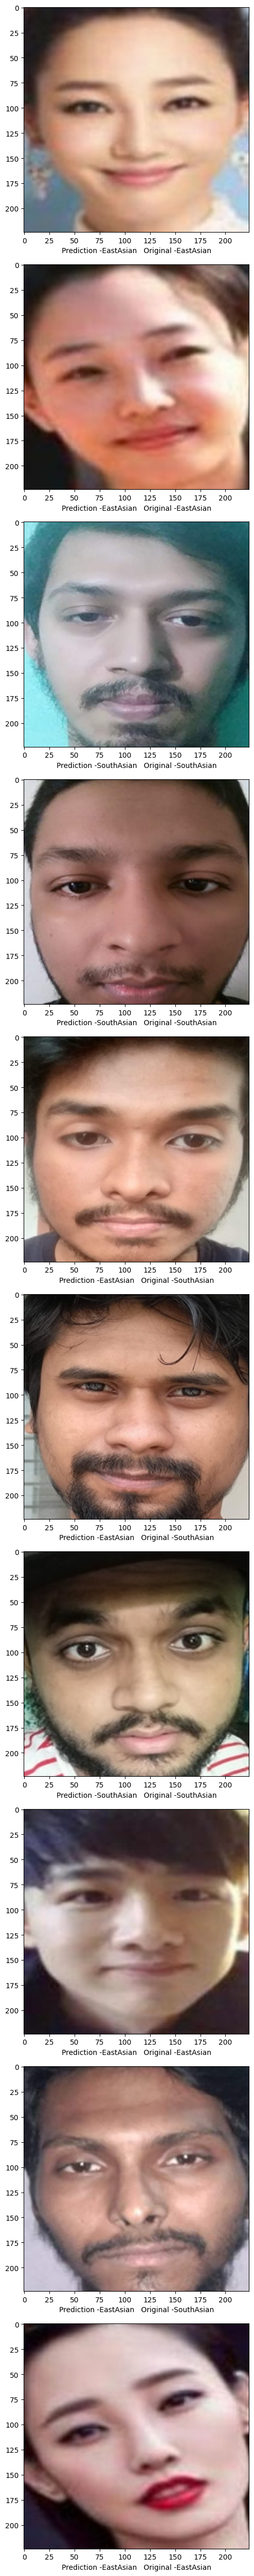

In [ ]:
#visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(10):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [ ]:
#classiication report
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

   EastAsian       0.62      1.00      0.77        15
  SouthAsian       1.00      0.40      0.57        15

    accuracy                           0.70        30
   macro avg       0.81      0.70      0.67        30
weighted avg       0.81      0.70      0.67        30



Confusion matrix

Text(0.5, 1.0, 'Confusion_matrix')

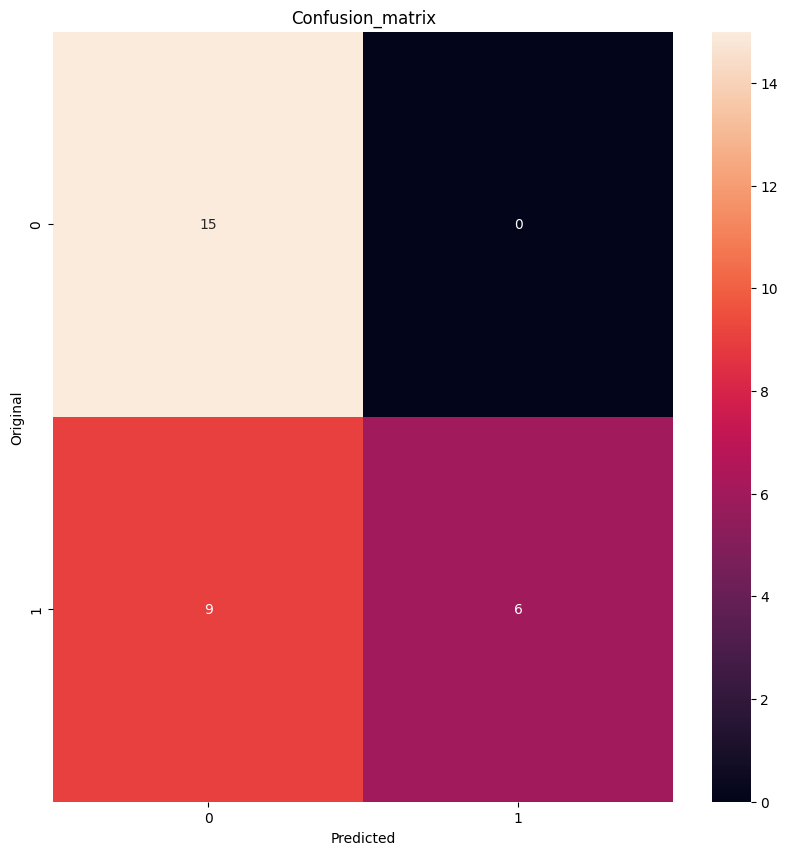

In [ ]:
#plotting confusion matrix
import seaborn as sns

plt.figure(figsize=(10,10))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')


In [ ]:
 np.asarray(prediction)

array(['SouthAsian', 'EastAsian', 'SouthAsian', 'SouthAsian',
       'SouthAsian', 'EastAsian', 'EastAsian', 'EastAsian', 'EastAsian',
       'EastAsian', 'SouthAsian', 'SouthAsian', 'EastAsian', 'EastAsian',
       'EastAsian', 'EastAsian', 'EastAsian', 'EastAsian', 'EastAsian',
       'EastAsian', 'EastAsian', 'EastAsian', 'EastAsian', 'EastAsian',
       'EastAsian', 'EastAsian', 'EastAsian', 'EastAsian', 'EastAsian',
       'EastAsian'], dtype='<U10')

Generate heatmap

In [ ]:
def grad_cam(img):

  #Covert the image to array of type float32
  img = np.asarray(img, dtype= np.float32)

  #Reshape the image from (224,224,3) to (1,224,224,3)
  img = img.reshape(-1,224,224,3)
  img_scaled = img / 255


  classification_layers = ["Averagea_Pooling","Dense_final"]

  #Last convolutional layer in the base mdel, this woun't change as name has been already assigned to it.
  final_conv = model.get_layer("res_5_identity_2_c")

  #Create a model with original model input as input and the last conv_layer as the output
  final_conv_model = keras.Model(model.inputs, final_conv.output)

  #Then,we create the input for classification layer, which is the output of last conv layer
  #In our case, output produced by the conv layer is of the shape (1,3,3,2048)
  #Since, the classification input needs the features as input, we ignore the batch dimension

  classification_input = keras.Input(shape=final_conv.output.shape[1:])

  # We iterate through the classification layers, to get the final layer and then, append
  #the layer as the output layer to the classification model.
  temp = classification_input
  for layer in classification_layers:
      temp = model.get_layer(layer)(temp)
  classification_model = keras.Model(classification_input, temp)


  #We use gradient tape to monitor the 'final_conv_output' to retrive the gradients
  #corresponding to the predicted class
  with tf.GradientTape() as tape:
      # Pass the image through the base model and get the feature map
      final_conv_output = final_conv_model(img_scaled)

      #Assign gradient tape to monitor the conv_output
      tape.watch(final_conv_output)

      #Pass the feature map through the classification model and use argmax to get the
      #index of the predicted class and then use the index to get the value produced by final
      #layer for that class
      prediction = classification_model(final_conv_output)

      predicted_class = tf.argmax(prediction[0][0][0])

      predicted_class_value = prediction[:,:,:,predicted_class]

  #Get the gradient corresponding to the predicted class based on feature map.
  #which is of shape (1,3,3,2048)
  gradient = tape.gradient(predicted_class_value, final_conv_output)

  #Since we need the filter values (2048), we reduce the other dimensions,
  #hich would result in a shape of (2048,)
  gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

  #We then convert the feature map produced by last conv layer(1,6,6,1536) to (6,6,1536)

  final_conv_output = final_conv_output.numpy()[0]

  gradient_channels = gradient_channels.numpy()

  #We multiply the filters in the feature map produced by final conv layer by the
  #filter values that are used to get the predicted class. By doing this we inrease the
  #value of areas that helped in making the prediction and lower the vlaue of areas, that
  #did not contribute towards the final prediction
  for i in range(gradient_channels.shape[-1]):
      final_conv_output[:, :, i] *= gradient_channels[i]

  #We take the mean accross the channels to get the feature map
  heatmap = np.mean(final_conv_output, axis=-1)

  #Normalizing the heat map between 0 and 1, to visualize it
  heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

  # Rescaling and converting the type to int
  heatmap = np.uint8(223 * heatmap_normalized )

  # Create the colormap
  color_map = plt.cm.get_cmap('jet')

  # get only the rb features from the heatmap
  color_map = color_map(np.arange(224))[:, :3]
  heatmap = color_map[heatmap]

  #convert the array to image, resize the image and then convert to array
  heatmap = keras.preprocessing.image.array_to_img(heatmap)
  heatmap = heatmap.resize((224, 224))
  heatmap = np.asarray(heatmap, dtype = np.float32)

  # Add the heatmap on top of the original image
  final_img = heatmap * 0.4 + img[0]
  final_img = keras.preprocessing.image.array_to_img(final_img)

  return final_img, heatmap_normalized

<ipython-input-24-4b763f1c4404>:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('jet')


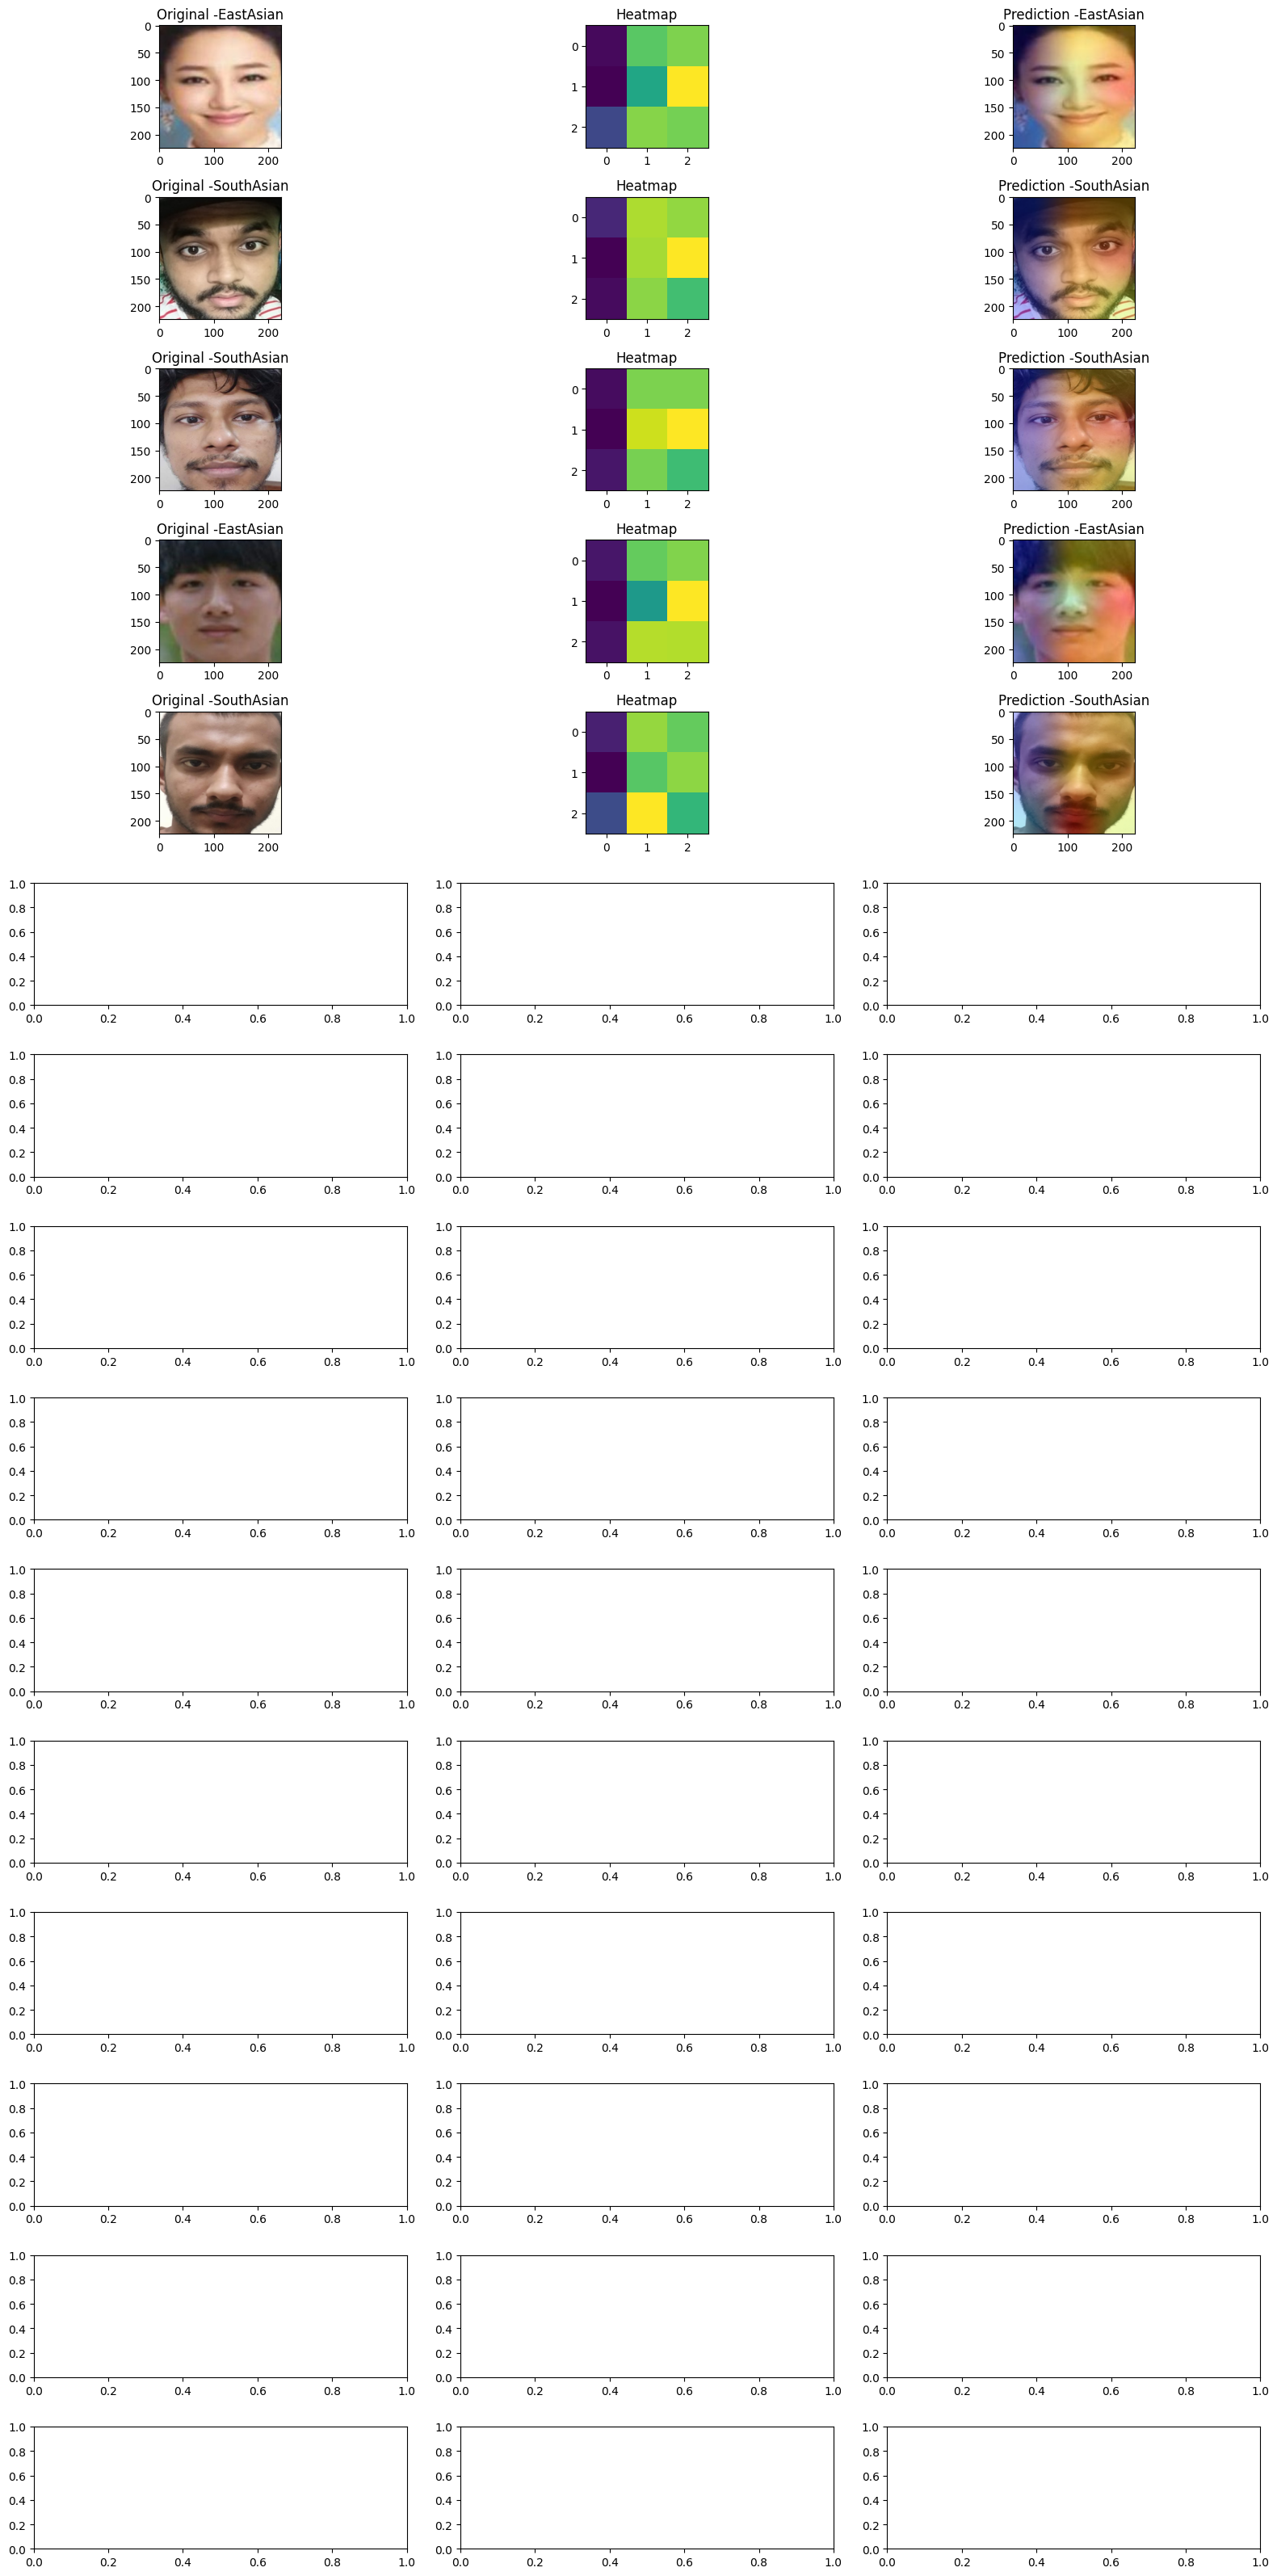

In [ ]:
#Visualize the images in the dataset

from tensorflow import keras
import random
fig, axs = plt.subplots(15,3, figsize=(16,32))
count = 0
for _ in range(5):
  i = random.randint(0,len(image))
  gradcam, heatmap = grad_cam(image[i])
  axs[count][0].title.set_text("Original -" + original[i])
  axs[count][0].imshow(image[i])
  axs[count][1].title.set_text("Heatmap")
  axs[count][1].imshow(heatmap)
  axs[count][2].title.set_text("Prediction -" + prediction[i])
  axs[count][2].imshow(gradcam)
  count += 1

fig.tight_layout()